In [3]:
## The clump identification and photometry code from Sattari et al. 2023
# contact info: zahra.sattari@email.ucr.edu

import numpy as np
from photutils import deblend_sources
from photutils import SourceCatalog
from photutils.segmentation import SourceCatalog
from photutils.aperture import CircularAperture
from photutils.aperture import aperture_photometry
from photutils.aperture import CircularAperture, CircularAnnulus
from photutils.aperture import ApertureStats
import cv2
from scipy import fftpack
from astropy.convolution import Gaussian2DKernel
from photutils.segmentation import deblend_sources
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
from astropy.stats import bootstrap
from astropy.coordinates import SkyCoord as skycoord
from astropy.io import fits as pyfits
from astropy.convolution import convolve
from photutils import detect_threshold

# from Functions import *
import os
import random
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import matplotlib.pylab as plt
from astropy.table import Table
from pynverse import inversefunc
#setting of the figures
font = {'family' : 'serif','size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['figure.dpi']= 100
#########################
import pandas as pd
# setting of pandas dataframes
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 100)
##########################
#Hide warnings caused by devision by zero which returns nan value
import warnings
warnings.filterwarnings('ignore')
from astropy.io import fits
from astropy.wcs import WCS
from astropy.wcs.utils import skycoord_to_pixel
#functions to get comoving distance from redshift and vice versa
from astropy.cosmology import FlatLambdaCDM
cosmo2 = FlatLambdaCDM(H0=70, Om0=0.3)
from colossus.cosmology.cosmology import *
cosmo=setCosmology('planck15-only')
from glob import glob
import time
import astropy.units as u
import copy
##########################
def Comoving(z):
    """A function which takes redshift and returns comoving distance in Mpc/h"""
    Comoving = cosmo.comovingDistance(z_min=0.0, z_max=z, transverse=True)
    return Comoving
##########################
def Redshift(X):
    """A function which takes comoving distance in Mpc/h and returns redshift"""

    z=inversefunc(Comoving, X)
    return z

def ftouJy(flux, band):
    """
    Convert flux from given units to microjansky (μJy) based on the band.
    
    Parameters:
        flux (float): Flux value to be converted.
        band (str): Bandpass filter name (e.g., 'uv', 'b', 'v', etc.).
    
    Returns:
        float: Flux value in microjansky.
    """
    zp = {'b': 25.673, 'v': 26.486, 'i': 25.933, 'z': 24.862, 'y': 26.2687, 'j': 26.2303, 'h': 25.9463, 'uv': 24.1889}
    
    # Conversion formula: Flux_microjansky = Flux * 10^((zp - 8.9) / 2.5)
    flux_microjansky = flux * (10 ** ((zp[band] - 8.9) / -2.5)) * 1e6
    
    return flux_microjansky

##########################

#### Read catalogs


goodss=pd.read_csv('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/Codes/filtered_data_table_goodss4.csv')
# goodsn=pd.read_csv('goodsn.csv')
# goodss=pd.read_csv('cosmos.csv')
# egs=pd.read_csv('egs.csv')




# goodss=cosmos.rename(columns={'WFC3_F435W_FLUX_IMPROVED':'ACS_F435W_FLUX'})
# egs=egs.rename(columns={'WFC3_F435W_FLUX_IMPROVED':'ACS_F435W_FLUX'})

zp={'b':25.673,'v':26.486,'i':25.933,'z':24.862,'y':26.2687,'j':26.2303,'h':25.9463 , 'uv':24.1889}
def uJy_to_count(f,band):
    return f*(10**-6)*(10**((zp[band]-8.9)/2.5))


#### Class to identify clumps and make catalogs and save figures


psf_h=fits.open('/Users/neal/Documents/PhD/projects/SED-fitting/Clump/psfs/goodss_3dhst_v4.0_wfc3_psf/goodss_3dhst.v4.0.F160W_psf.fits')[0]

psf=psf_h.data

ic=psf.shape[0]/2
jc=psf.shape[1]/2
def psf_f(R):
    f=0
    for i in range(psf.shape[0]):
        for j in range(psf.shape[1]):
            if np.sqrt((i-ic)**2+(j-jc)**2)<R:
                f=f+psf[i,j]
    return f
psf_f=np.vectorize(psf_f)

# finds the fields
class field (object):
    
    def __init__(self, field_name, data_dir):
        
        self.field_name=field_name
        self.data_dir=data_dir
        
        if field_name=='goodss':
        
            self.catalog=copy.deepcopy(goodss)
        if field_name=='goodsn':
        
            self.catalog=copy.deepcopy(goodsn)
        if field_name=='cosmos':
        
            self.catalog=copy.deepcopy(cosmos)
        if field_name=='egs':
        
            self.catalog=copy.deepcopy(egs)
    #open the bandpass
    # def set_band(self,band):
        
    #     self.band=band
        
    #     file_name=self.data_dir+'/mosaics/'+self.field_name+'_'+band+'.fits'
    #     file_name_err=self.data_dir+'/mosaics/'+self.field_name+'_err_'+band+'.fits'
    #     self.header=fits.open(file_name)[0].header
    #     self.fits=fits.open(file_name)[0]
    #     self.fits_err=fits.open(file_name_err)[0]
    #     self.mosaic=fits.open(file_name)[0].data
    #     self.mosaic_err=fits.open(file_name_err)[0].data
        
    #     return self
    def set_band(self, band):
        self.band = band
        base_dir = '/Users/neal/Documents/PhD/projects/SED-fitting/Clump/GOODSS'
        file_name = os.path.join(base_dir, f'{self.field_name}_all_acs_wfc_{band}_060mas_v1.5_drz.fits')
        file_name_err = os.path.join(base_dir, f'{self.field_name}_all_acs_wfc_{band}_060mas_v1.5_wht.fits') 
        
        self.header = fits.open(file_name)[0].header
        self.fits = fits.open(file_name)[0]
        self.fits_err = fits.open(file_name_err)[0]
        self.mosaic = fits.open(file_name)[0].data
        self.mosaic_err = fits.open(file_name_err)[0].data
        
        return self
    
            
    def cutout(self,r_cut='None',a_factor=2.5):
        if r_cut=='None':
            self.r_cut=a_factor*self.a
        else:
        
            self.r_cut=r_cut
        
        # going from coodrinates to pixels
        def RADEC2XY(ra,dec):
            wcs=WCS(self.header)
            coords = skycoord(ra,dec, unit='deg',frame='icrs')
            a=skycoord_to_pixel(coords, wcs, origin=0,mode=u'wcs')
            return float(a[0]),float(a[1])
        self.x,self.y=RADEC2XY(self.RA,self.DEC)
        self.image=self.fits.section[int(self.y-int(self.r_cut)):int(self.y+int(self.r_cut)),int(self.x-int(self.r_cut)):int(self.x+int(self.r_cut))]
        self.image_err=self.fits_err.section[int(self.y-int(self.r_cut)):int(self.y+int(self.r_cut)),int(self.x-int(self.r_cut)):int(self.x+int(self.r_cut))]

        # modification by Niloo Sharei on 3/6/24
        # using weight images, which are inverse variance
        # inverting self.image_err and taking square root to account for this

        self.image_err = np.sqrt( np.ones( (self.image_err.shape[0], self.image_err.shape[1]) ) / self.image_err )

        return self
    #matching 
    def hpsf_matched(self):
        if self.band!='h':      
            Path='/Users/neal/Documents/PhD/projects/SED-fitting/Clump/' #self.data_dir+'/catalog_n/'
            kernel=pyfits.getdata(Path+'kernel'+self.band+'2h.fits')
            self.image=convolve(self.image,kernel)
            self.image_err=convolve(self.image_err,kernel)
        return self
    
    def plot(self,err=False):
        if err:
            fig, ax = plt.subplots(1, 2,  figsize=(10,20))

            
            ax[0].imshow(self.image,origin='lower')
            ax[0].set_title('band: '+self.band,fontsize=18)
            ax[0].axes.xaxis.set_visible(False)
            ax[0].axes.yaxis.set_visible(False)
            ax[1].imshow(self.image_err,origin='lower')
            ax[1].set_title('band: '+self.band+', error',fontsize=18)
            ax[1].axes.xaxis.set_visible(False)
            ax[1].axes.yaxis.set_visible(False)
            plt.show()
        if not err:
            fig, ax = plt.subplots(1, 1,  figsize=(5,5))
            ax.imshow(self.image,origin='lower')
            ax.set_title('band: '+self.band,fontsize=18)
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
            plt.show()
            
        
    def rest_uv(self,ID):
        self.ID=ID
        self.RA= float(self.catalog[self.catalog.ID==ID].RA_1)
        self.DEC=float(self.catalog[self.catalog.ID==ID].DEC_1)
        self.z=float(self.catalog[self.catalog.ID==ID].kodra_z_best)
        self.a=float(self.catalog[self.catalog.ID==ID].A_IMAGE)
        
        if 0.5<=self.z<1:
            self.set_band('uv')
            self.rest_uv_flux=float(self.catalog[self.catalog.ID==ID]['WFC3_F275W_FLUX_IMPROVED'])
        elif 1<=self.z<2:
            self.set_band('b')
            self.rest_uv_flux=float(self.catalog[self.catalog.ID==ID]['ACS_F435W_FLUX'])
        elif 2<=self.z<=3:
            self.set_band('v')
            self.rest_uv_flux=float(self.catalog[self.catalog.ID==ID]['ACS_F606W_FLUX'])
        else:
            print('wrong redshift!')
        return self
            
    def gal_ID(self,ID):
        self.ID=ID
        self.RA= float(self.catalog[self.catalog.ID==ID].RA_1)
        self.DEC=float(self.catalog[self.catalog.ID==ID].DEC_1)
        self.z=float(self.catalog[self.catalog.ID==ID].kodra_z_best)
        self.a=float(self.catalog[self.catalog.ID==ID].A_IMAGE)
        return self
    
    def clump(self,sigma_thresh=1.5,S_to_Noise=3):
        #sigma treshold
        self.sigma_thresh=sigma_thresh
        
        k=self.image
        euv_cut=self.image_err
        
        Z_fft = fftpack.fft2(k)
        Z_shift = fftpack.fftshift(Z_fft)

        power=np.abs(Z_shift)**2
        power_log=np.log10(power)

        power2=np.abs(Z_fft)**2


        import scipy.optimize as opt
        import math 

        def twoD_Gaussian(xdata_tuple, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
            (x, y) = xdata_tuple                                                        
            xo = float(xo)                                                              
            yo = float(yo)                                                              
            a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)   
            b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)    
            c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)   
            g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo)         
                                + c*((y-yo)**2)))                                   
            return g.ravel()

        initial_guess = (power[int(k.shape[0]/2),int(k.shape[0]/2)],k.shape[0]/2,k.shape[0]/2,2,2,0,0)

        x = np.arange(0, k.shape[0])
        y = np.arange(0, k.shape[1])
        x, y = np.meshgrid(x, y)
        try:
            self.popt, self.pcov = opt.curve_fit(twoD_Gaussian,(x,y), power.ravel(), p0=initial_guess,bounds=[(- inf, inf),(0,k.shape[0]),(0,k.shape[1]),(0,inf),(0,inf),(0,2*np.pi),(- inf, inf)])
        except:
            self.popt=initial_guess 


        self.Z_fft = fftpack.fft2(k)
        self.Z_shift = fftpack.fftshift(Z_fft)

        self.power=np.abs(Z_shift)**2
        self.power_log=np.log10(self.power)



        #make filter
        cent=int(np.shape(k)[0]/2)
        filter_=np.ones((2*cent,2*cent))
        filter_size_x=int(math.ceil(np.abs(self.popt[3])))
        filter_size_y=int(math.ceil(np.abs(self.popt[4])))

        filter_[cent-filter_size_x:cent+filter_size_x,cent-filter_size_y:cent+filter_size_y]=0


        cent=int(np.shape(k)[0]/2)
        filter_bkg=np.zeros((2*cent,2*cent))


        filter_bkg[cent-filter_size_x:cent+filter_size_x,cent-filter_size_y:cent+filter_size_y]=1


        self.sbt=fftpack.ifft2(fftpack.ifftshift(filter_*self.Z_shift)).real
        self.bkg=fftpack.ifft2(fftpack.ifftshift(filter_bkg*self.Z_shift)).real

        
        threshold =detect_threshold(self.sbt, nsigma=sigma_thresh)


        sigma = 2 * gaussian_fwhm_to_sigma   
        kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
        convolved_data = convolve(self.sbt, kernel, normalize_kernel=True)

        self.segm = detect_sources(convolved_data, threshold, npixels=4)
        
        if self.segm==None:
            
            self.status='no_clump'
            self.clumps=np.array([])
            
        else:
            
            self.status='clump'
            
            self.segm_deblend = deblend_sources(convolved_data,  self.segm, npixels=4,nlevels=32)

            center=self.r_cut, self.r_cut
            cat = SourceCatalog(k,self.segm_deblend )
            tbl = cat.to_table()
            ###########
            self.clumps=tbl.to_pandas()

            if S_to_Noise:

                SNC=np.zeros((len(self.clumps)))
                flux_ratio=np.zeros((len(self.clumps)))
                for j in range (0,len(self.clumps)):
                    c0=self.segm_deblend.data==self.clumps.label.iloc[j]
                    SNC[j]= np.sum(k*c0)/np.sqrt(np.sum((euv_cut*c0)**2))


                self.clumps['SNC']=SNC
                self.clumps=self.clumps[self.clumps.SNC>=S_to_Noise]
            
            self.clumps['number']=np.arange(1,len(self.clumps)+1,1)
            
        if (len(self.clumps!=0)):
            if self.status!='no_clump':
                self.x_c=[]
                self.y_c=[]

                # modification by Niloo Sharei on 3/6/24
                # creating arrays of the RAs and DECs of the clumps
                wcs=WCS(self.header)
                self.ra_clump = []
                self.dec_clump = []

                for j in range (0,len(self.clumps)):
                    c0=self.segm_deblend.data==self.clumps.label.iloc[j]
                    where=np.argwhere(self.sbt*c0==np.max(self.sbt*c0))
                    self.x_c.append(where[0][0])
                    self.y_c.append(where[0][1])
                    
                    ######## Where i think this should be added

              
                    #     # Get the WCS information from the header
                    # wcs = WCS(self.header)

                    # # Convert pixel coordinates to RA and Dec
                    
                    ra_clump, dec_clump = wcs.all_pix2world(where[0][1] + int(self.x-int(self.r_cut)), where[0][0] + int(self.y-int(self.r_cut)), 0)

                    self.ra_clump.append(ra_clump)
                    self.dec_clump.append(dec_clump)

                    # # Store the RA and Dec of clumps along with other clump properties
                    # self.clumps['RA_clump'] = ra_clump
                    # self.clumps['Dec_clump'] = dec_clump
        
        return self
    
    def plot_clumps(self,save=False):
        fig,(ax) = plt.subplots(1, 4,  figsize=(15,5))
        fig.subplots_adjust(wspace=0.1)
        
        self.h_cutout=fits.open(self.data_dir+'/mosaics/'+self.field_name+'_h.fits')[0].section[int(self.y-int(self.r_cut)):int(self.y+int(self.r_cut)),int(self.x-int(self.r_cut)):int(self.x+int(self.r_cut))]
        ax[0].imshow(self.h_cutout,origin='lower')
        ax[0].set_title('F160W',fontsize=19)
        ax[0].axes.xaxis.set_visible(False)
        ax[0].axes.yaxis.set_visible(False) 

        ax[1].imshow(self.image,origin='lower')
        ax[1].set_title('Rest UV',fontsize=19)
        ax[1].axes.xaxis.set_visible(False)
        ax[1].axes.yaxis.set_visible(False)


        ax[2].imshow(self.bkg,origin='lower')
        ax[2].set_title('Background',fontsize=19)
        ax[2].axes.xaxis.set_visible(False)
        ax[2].axes.yaxis.set_visible(False)
        
        if (len(self.clumps!=0)):
            if self.status!='no_clump':

                ax[3].imshow(self.sbt,origin='lower')
                ax[3].scatter(self.y_c,self.x_c,ec='deeppink',c='None',s=500,linewidth=2)
                for k in range(len(self.x_c)):
                    ax[3].text(self.y_c[k],self.x_c[k],str(round(self.clumps.flux_ratio.iloc[k]*100))+'\%',color='white',va='center',ha='center')

        else:
            ax[3].imshow(self.image)
            ax[3].fill_between(np.arange(-1,3* self.r_cut),-1, 3* self.r_cut,hatch='//',facecolor='white')
            
        ax[3].set_title('Clumps',fontsize=19)
        ax[3].axes.xaxis.set_visible(False)
        ax[3].axes.yaxis.set_visible(False)

        
        
        if save!=False:
            plt.savefig(save+self.field_name+'_'+str(self.ID)+'.png',bbox_inches='tight')
        plt.show()
        
        return self

    
    def plot_paper(self,save=False,title=True,cmap='GnBu'):
        fig,(ax) = plt.subplots(1, 3,  figsize=(15,5))
        fig.subplots_adjust(wspace=0.1)
        
        self.h_cutout=fits.open(self.data_dir+'/mosaics/'+self.field_name+'_h.fits')[0].section[int(self.y-int(self.r_cut)):int(self.y+int(self.r_cut)),int(self.x-int(self.r_cut)):int(self.x+int(self.r_cut))]
        ax[0].imshow(self.h_cutout,origin='lower',cmap=cmap)
        if title:
            ax[0].set_title('F160W',fontsize=19)
        ax[0].axes.xaxis.set_visible(False)
        ax[0].axes.yaxis.set_visible(False) 

        ax[1].imshow(self.image,origin='lower',cmap=cmap)
        if title:
            ax[1].set_title('Rest-frame UV 1600\AA',fontsize=19)
        ax[1].axes.xaxis.set_visible(False)
        ax[1].axes.yaxis.set_visible(False)

        
        if (len(self.clumps!=0)):
            if self.status!='no_clump':

                ax[2].imshow(self.sbt,origin='lower',cmap=cmap)
                self.x_c=[]
                self.y_c=[]

                for j in range (0,len(self.clumps)):
                    c0=self.segm_deblend.data==self.clumps.label.iloc[j]
                    where=np.argwhere(self.sbt*c0==np.max(self.sbt*c0))
                    self.x_c.append(where[0][0])
                    self.y_c.append(where[0][1])


                ax[2].scatter(self.y_c,self.x_c,ec='deeppink',c='None',s=700,linewidth=2)

        else:
            ax[2].imshow(self.image,cmap=cmap)
            ax[2].fill_between(np.arange(-1,3* self.r_cut),-1, 3* self.r_cut,hatch='//',facecolor='white')
            
        if title:
            
            ax[2].set_title('Identified Clumps',fontsize=19)
        ax[2].axes.xaxis.set_visible(False)
        ax[2].axes.yaxis.set_visible(False)

        
        
        if save!=False:
            plt.savefig(save+self.field_name+'_'+str(self.ID)+'.pdf',bbox_inches='tight')
        plt.show()
        
        return self
    

    def plot_fig1(self,save=False,title=True,cmap='GnBu'):
        fig,(ax) = plt.subplots(1, 4,  figsize=(16,5))
        fig.subplots_adjust(wspace=0.1)
        
        ujy=ftouJy(self.image,self.band)
        
        fou = fftpack.fft2(ujy)
        fou_shift = fftpack.fftshift(fou)

        fou_power=np.abs(fou_shift)**2
        fou_power_log=np.log10(fou_power)
        
        
        
        
        im0=ax[0].imshow(ujy,origin='lower',cmap=cmap)
        if title:
            ax[0].set_title('(a)\\ Rest-frame UV 1600\AA',fontsize=19)
        ax[0].axes.xaxis.set_visible(False)
        ax[0].axes.yaxis.set_visible(False)
        fig.colorbar(im0,ax=ax[0],orientation="horizontal", pad=0.02).set_label(label='Flux $(\\rm \mu Jy)$',size=20)


        im1=ax[1].imshow(fou_power_log,origin='lower',cmap=cmap)
        if title:
            
            ax[1].set_title('(b)\\ Power Spectrum',fontsize=19)
        ax[1].axes.xaxis.set_visible(False)
        ax[1].axes.yaxis.set_visible(False)
        fig.colorbar(im1,ax=ax[1],orientation="horizontal", pad=0.02).set_label(label='log P',size=20)

        
        im2=ax[2].imshow(ftouJy(self.bkg,self.band),origin='lower',cmap=cmap)
        if title:
            
            ax[2].set_title('(c)\\ Background',fontsize=19)
        ax[2].axes.xaxis.set_visible(False)
        ax[2].axes.yaxis.set_visible(False)    
        fig.colorbar(im2,ax=ax[2],orientation="horizontal", pad=0.02).set_label(label='Flux $(\\rm \mu Jy)$',size=20)

        
        im3=ax[3].imshow(ftouJy(self.sbt,self.band),origin='lower',cmap=cmap)
        if title:
            
            ax[3].set_title('(d)\\ Background Subtracted',fontsize=19)
        ax[3].axes.xaxis.set_visible(False)
        ax[3].axes.yaxis.set_visible(False)
        fig.colorbar(im3,ax=ax[3],orientation="horizontal", pad=0.02).set_label(label='Flux $(\\rm \mu Jy)$',size=20)

        
        
        if save!=False:
            plt.savefig(save+self.field_name+'_'+str(self.ID)+'_fig1.pdf',bbox_inches='tight')
        plt.show()
        
        return self
    
    def photometry(self):
        
        flux_ratio=[]
        if (len(self.clumps!=0)):
            if self.status!='no_clump':
                for i in range(len(self.x_c)):

# aperture photomerty..sumup the pixels in aradius at those posotions.
                    positions = self.y_c[i],self.x_c[i]
                    aperture = CircularAperture(positions, r=3)
                    #background substraction
                    annulus_aperture = CircularAnnulus(positions, r_in=6, r_out=10)

                    masked=np.zeros_like(self.image).astype(bool)


                    #looping thru everyhtinh else
                    #segmentation:
                    for j in np.delete(np.arange(len(self.x_c)),i):
                        c0=self.segm_deblend.data==self.clumps.label.iloc[j]
                        masked=masked+c0




                    phot_table = aperture_photometry(self.image, aperture,mask=masked)
                    aperstats = ApertureStats(self.image, annulus_aperture,mask=masked)
                    bkg_mean = aperstats.mean

                    aperture_area = aperture.area_overlap(self.image,mask=masked)

                    total_bkg = bkg_mean * aperture_area

                    phot_bkgsub = phot_table['aperture_sum'] - total_bkg

                    phot_table['total_bkg'] = total_bkg
                    phot_table['aperture_sum_bkgsub'] = phot_bkgsub
                    phot_table['flux_tot'] =ftouJy(phot_bkgsub/psf_f(3),self.band)



                    flux_ratio.append(float(phot_table['flux_tot']/self.rest_uv_flux))


                self.clumps['flux_ratio']=flux_ratio
                self.clumps['restuv_flux']=self.rest_uv_flux

        return self
            


        



In [4]:
#  Run the function for the GOODSS field
result_sample_fname='/Users/neal/Documents/PhD/projects/SED-fitting/Clump/results/catalog_n/goodsslast.csv'
goodss_result=open(result_sample_fname,'w')
goodss_result.close()


goodss_result=pd.DataFrame(columns=['Field','CANDELS_ID','z','RA_gal','DEC_gal','A','Clump_ID','dist_clump','flux_ratio','restuv_flux', 'RA_clump', 'DEC_clump'],dtype=object)

goodss_result.to_csv(result_sample_fname)
field_goodss=field('goodss','/Clump')

Field=[]
CANDELS_ID=[]
z=[]
RA_gal=[]
DEC_gal=[]

# modification
ra_clump = []
dec_clump = []

A=[]
Clump_ID=[]
dist_clump=[]
flux_ratio=[]
restuv_flux=[]
####################
# RA_clump=[]
# Dec_clump=[]
for i in goodss.ID:
    field_goodss.rest_uv(i).cutout().hpsf_matched().clump().photometry()#.plot_clumps(save='/results/images/')
    if  len(field_goodss.clumps)==0:
        Field.append(field_goodss.field_name)
        CANDELS_ID.append(field_goodss.ID)
        z.append(field_goodss.z)
        RA_gal.append(field_goodss.RA)
        DEC_gal.append(field_goodss.DEC)
        A.append(field_goodss.a)
        Clump_ID.append(-99)
        dist_clump.append(-99)
        flux_ratio.append(-99)
        restuv_flux.append(-99)

        ra_clump.append(-99)
        dec_clump.append(-99)
    else:
        for j in field_goodss.clumps.number:
            Field.append(field_goodss.field_name)
            CANDELS_ID.append(field_goodss.ID)
            z.append(field_goodss.z)
            RA_gal.append(field_goodss.RA)
            DEC_gal.append(field_goodss.DEC)
            A.append(field_goodss.a)
            Clump_ID.append(j)
            dist_clump.append(np.sqrt(((field_goodss.x_c[j-1]-field_goodss.r_cut)**2)+((field_goodss.y_c[j-1]-field_goodss.r_cut)**2)))
            flux_ratio.append(field_goodss.clumps.flux_ratio.iloc[j-1])
            restuv_flux.append(field_goodss.clumps.restuv_flux.iloc[j-1])

            ra_clump.append(field_goodss.ra_clump[j-1])
            dec_clump.append(field_goodss.dec_clump[j-1])
            
            
goodss_result['Field']=Field
goodss_result['CANDELS_ID']=CANDELS_ID
goodss_result['z']=z
goodss_result['RA_gal']=RA_gal
goodss_result['DEC_gal']=DEC_gal
goodss_result['A']=A
goodss_result['Clump_ID']=Clump_ID
goodss_result['dist_clump']=dist_clump
goodss_result['flux_ratio']=flux_ratio
goodss_result['restuv_flux']=restuv_flux

goodss_result['RA_clump'] = ra_clump
goodss_result['DEC_clump'] = dec_clump


goodss_result.to_csv(result_sample_fname)

Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 1/1 [00:00<00:00, 682.11it/s]
Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 6/6 [00:00<00:00, 19.57it/s]
Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 1/1 [00:00<00:00, 573.78it/s]
Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 3/3 [00:00<00:00, 731.73it/s]
Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 1/1 [00:00<00:00, 524.09it/s]
Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 1/1 [00:00<00:00, 682.00it/s]
Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 2/2 [00:00<00:00, 679.13it/s]
Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 1/1 [00:00<00:00, 500.27it/s]
Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 6/6 [00:00<00:00, 807.66it/s]
Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 1/1 [00:00<00:00, 597.82it/s]
Deblending: 0it [00:00, ?it/s]
Deblending: 100%|██████████| 8/8 [00:00<00:00, 923.07it/s]
Deblending:

In [4]:
print(field_goodss.ra_clump[0])

53.085063964709065


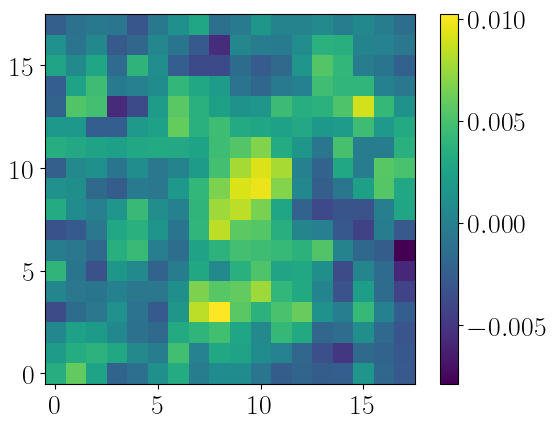

14263.794877917306
[14, 29, 43]
[26, 15, 24]


In [5]:
plt.imshow(field_goodss.image, origin='lower')
plt.colorbar()
plt.show()

print(field_goodss.x)
print(field_goodss.x_c)
print(field_goodss.y_c)

In [6]:
c0=field_goodss.segm_deblend.data==field_goodss.clumps.l
np.argwhere(field_goodss.sbt*c0==np.max(field_goodss.sbt*c0))

AttributeError: 'numpy.ndarray' object has no attribute 'l'